In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
import keras

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

Using TensorFlow backend.
2019-04-04 19:02:35,033 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Running the following at the terminal provides (after a few seconds of thinking) the total line length of the file.

```
% wc -l data/train.csv 
629145481 data/train.csv
```

Certainly too much for my pathetic laptop to read all at once. 

## Loading Sample Data

What do the first 10,000,000 lines look like?

In [10]:
sample_raw_data = pd.read_csv('data/train.csv', sep=',', nrows=10000000)

In [11]:
sample_raw_data.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


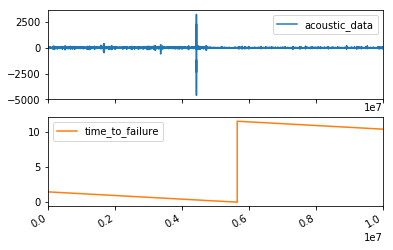

In [12]:
sample_raw_data.plot(subplots=True);

In [13]:
sample_raw_data['time_to_failure'].min()

0.0007954798229500001

Clearly the step size is super tiny here. Interesting little bump maybe 200-300ms before "failure". 

## Counting Number of Quake Events

Ok let's see if I can read in the data bit by bit and figure out how many quakes are in the full training file.

In [6]:
np.sum(sample_raw_data['time_to_failure'].diff().shift(-1) > 0)

1

In [7]:
train_reader = pd.read_csv('data/train.csv', sep=',', chunksize=10000000)

quakes = 0
for chunk in train_reader:
    quakes += np.sum(chunk['time_to_failure'].diff().shift(-1) > 0)
    
    
print(quakes)

16


I'd like to take a closer look at one of the sections of data and apply some transforms to see if anything stands out.

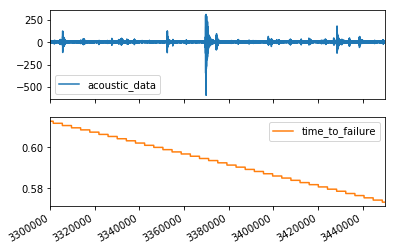

In [14]:
bump_start = 3300000

bump_sample = sample_raw_data.loc[bump_start:bump_start + 150000 - 1]
bump_sample.plot(subplots=True);

In [15]:
t_step = -np.mean(bump_sample['time_to_failure'].diff().shift(-1))
t_step

2.6199035793571947e-07

## Loading Specific Data Chunks With Pandas

In [6]:
specific_raw_data = pd.read_csv('data/train.csv', sep=',', skiprows=524328831, nrows=150000, header=0)

In [7]:
specific_raw_data.head()

,3,1.1563955383
0,7,1.156396
1,2,1.156396
2,2,1.156396
3,5,1.156396
4,4,1.156396


In [14]:
split_index = np.arange(0, 200)
np.random.choice(split_index, size=10)

array([ 76,  98, 137, 177, 124, 107,  47,  40,  59,  44])

In [5]:
# don't do this
#full_raw_data = pd.read_csv('data/train.csv', sep=',', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float16})

## Loading Data Chunks With Dask

In [2]:
import dask
import dask.dataframe as dd

In [3]:
data_dask = dd.read_csv("data/train.csv",  dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, blocksize=25e6)

In [4]:
array_dask = data_dask.to_dask_array(lengths=True)
array_dask = dask.array.rechunk(array_dask, chunks=(150000, 2))
array_dask[500000:510000:,]

dask.array<getitem, shape=(10000, 2), dtype=float64, chunksize=(10000, 2)>

In [5]:
array_dask[500000:510000:,].compute()

array([[ 1.        ,  1.33929967],
       [-2.        ,  1.33929967],
       [ 0.        ,  1.33929966],
       ...,
       [ 7.        ,  1.33719768],
       [ 2.        ,  1.33719768],
       [ 8.        ,  1.33719768]])

In [6]:
sample_index = np.random.choice(629145479, size=3)

data_list = []
target_list = []
for i in range(0, 3):
    sample_data = array_dask[sample_index[i]:sample_index[i]+150000].compute()
    data_list.append(sample_data[:,0])
    target_list.append(sample_data[-1,1])
    print(sample_data.shape)

(150000, 2)
(150000, 2)
(150000, 2)


In [7]:
n = 5
sample_index_start = np.random.choice(629145479, size=n)

In [8]:
l = 10
sample_index = [np.arange(i, i+l) for i in sample_index_start]
ts_sample = array_dask[:, 0][np.concatenate(sample_index)].reshape((n, l))
ts_sample.compute()

array([[ 2.,  2.,  2.,  6.,  8.,  9.,  3.,  5.,  8.,  8.],
       [ 3.,  3., 10.,  7.,  8.,  8.,  3.,  4.,  4.,  4.],
       [ 1.,  7.,  6.,  6.,  4.,  0.,  2.,  3.,  5.,  4.],
       [ 6.,  9.,  9.,  4.,  9., 10.,  5.,  3.,  4.,  1.],
       [-3.,  2.,  0.,  4.,  8.,  4.,  7.,  4.,  4.,  5.]])

In [9]:
st_size = 4
overlap_size = 2

# resample_index = np.concatenate([np.arange(i, i+st_size) for i in np.arange(0, l - st_size + 1, st_size - overlap_size)])
resample_index = np.concatenate([np.arange(i, i+st_size) for i in np.arange(l - st_size, -1, -(st_size - overlap_size))])
resample_index

array([6, 7, 8, 9, 4, 5, 6, 7, 2, 3, 4, 5, 0, 1, 2, 3])

In [10]:
ts_sample[:, resample_index].reshape((n, -1, st_size)).compute()

array([[[ 3.,  5.,  8.,  8.],
        [ 8.,  9.,  3.,  5.],
        [ 2.,  6.,  8.,  9.],
        [ 2.,  2.,  2.,  6.]],

       [[ 3.,  4.,  4.,  4.],
        [ 8.,  8.,  3.,  4.],
        [10.,  7.,  8.,  8.],
        [ 3.,  3., 10.,  7.]],

       [[ 2.,  3.,  5.,  4.],
        [ 4.,  0.,  2.,  3.],
        [ 6.,  6.,  4.,  0.],
        [ 1.,  7.,  6.,  6.]],

       [[ 5.,  3.,  4.,  1.],
        [ 9., 10.,  5.,  3.],
        [ 9.,  4.,  9., 10.],
        [ 6.,  9.,  9.,  4.]],

       [[ 7.,  4.,  4.,  5.],
        [ 8.,  4.,  7.,  4.],
        [ 0.,  4.,  8.,  4.],
        [-3.,  2.,  0.,  4.]]])

In [11]:
len(array_dask[:, 0])

629145480

In [12]:
n = 5
l = 100
st_size = 50
overlap_size = 25

def get_random_samples(x, n, l):
    sample_index_start = np.random.choice(len(x) - l, size=n)
    sample_index = [np.arange(i, i+l) for i in sample_index_start]
    samples = x[np.concatenate(sample_index)].reshape((n, l))
    return(samples, sample_index_start)

def overlapping_resample(x, sample_size, overlap_size):
    resample_index = np.concatenate([np.arange(i, i + sample_size) for i in np.arange(0, x.shape[1] - sample_size + 1, sample_size - overlap_size)])
    resample = x[:, resample_index].reshape((x.shape[0], -1, sample_size))
    return(resample)

ts_sample, sample_index = get_random_samples(array_dask[:, 0], n, l)
ts_resample = overlapping_resample(ts_sample, st_size, overlap_size)
target = array_dask[sample_index + l, 1]

In [13]:
ts_resample.shape

(5, 3, 50)

In [14]:
target.compute()

array([10.50179884,  3.0650966 ,  1.58009819,  4.09759571,  2.68139555])

In [15]:
dask.array.fft.fft(ts_resample)

dask.array<fft, shape=(5, 3, 50), dtype=complex128, chunksize=(1, 3, 50)>

In [16]:
sample_means = ts_resample.mean(axis=-1, keepdims=True)
sample_vars = ts_resample.var(axis=-1, keepdims=True)

In [17]:
sample_qts = [np.percentile(ts_resample, q=qt, axis=-1, keepdims=True) for qt in [1, 5, 50, 95, 99]]

In [18]:
dask.array.concatenate(sample_qts, axis=2).shape

(5, 3, 5)

In [19]:
sample_stats = dask.array.concatenate([sample_means, sample_vars, *sample_qts], axis=2)

In [20]:
sample_means.compute(), sample_vars.compute(), sample_stats.compute()

(array([[[ 4.96],
         [ 5.4 ],
         [ 4.88]],
 
        [[ 4.56],
         [ 4.38],
         [ 4.74]],
 
        [[-3.66],
         [14.24],
         [14.28]],
 
        [[ 5.18],
         [ 5.06],
         [ 4.56]],
 
        [[ 4.08],
         [ 4.82],
         [ 4.56]]]), array([[[8.4384000e+00],
         [8.0400000e+00],
         [6.7456000e+00]],
 
        [[8.4064000e+00],
         [5.3956000e+00],
         [5.4324000e+00]],
 
        [[4.4370644e+03],
         [4.4893824e+03],
         [6.5788816e+03]],
 
        [[6.5076000e+00],
         [6.8564000e+00],
         [7.4064000e+00]],
 
        [[8.6736000e+00],
         [8.9876000e+00],
         [9.7264000e+00]]]), array([[[ 4.9600000e+00,  8.4384000e+00, -1.0000000e+00,  4.5000000e-01,
           5.0000000e+00,  9.0000000e+00,  1.1020000e+01],
         [ 5.4000000e+00,  8.0400000e+00, -5.1000000e-01,  4.5000000e-01,
           5.0000000e+00,  1.0100000e+01,  1.1510000e+01],
         [ 4.8800000e+00,  6.7456000e+00, -1.0

## Loading Test Data with Dask

In [15]:
test_dd = dd.read_csv('data/test/*.csv')

In [18]:
test_dd.head()

,acoustic_data
0,4
1,0
2,-2
3,0
4,2


In [19]:
test_darray = test_dd['acoustic_data'].to_dask_array(lengths=True).reshape(-1, 150000)

In [23]:
from os import listdir

test_files = sorted(listdir('data/test'))

In [28]:
i = 1350
test_darray[i,:10].compute(), test_files[i]

(array([ 6, 10,  7,  7,  6,  8,  8,  4,  8,  5]), 'seg_87f6c8.csv')

## Testing the Data Loader Class

In [4]:
from prepare_data import LANLDataLoader

In [2]:
loader = LANLDataLoader()
data, target = loader.load_train_data()

KeyboardInterrupt: 

In [4]:
data[1].compute().shape

(200, 29, 2619)

In [69]:
target

dask.array<getitem, shape=(200,), dtype=float64, chunksize=(2,)>

In [8]:
data[0].shape[1:]

(29, 4)

In [5]:
loader.get_input_shape()

[(29,), (29,)]

In [8]:
train_args = {
    'n_samples': 40,
}
val_args = {
    'n_samples': 10
}
loader_args = {
    'st_size': 1500,
    'overlap_size': 500,
    'fft_f_cutoff': 500
}

loader = LANLDataLoader()
train_data, train_target, val_data, val_target = loader.load_train_val(
    train_args=train_args, val_args=val_args, loader_args=loader_args)

In [9]:
train_data[1].shape

(40, 149, 393)

## DFT (Discrete Fourier Transform)
Good info on implementation in the [numpy docs](https://docs.scipy.org/doc/numpy/reference/routines.fft.html#background-information)

In [17]:
from numpy.fft import fft

bump_fft = fft(bump_sample['acoustic_data'])

In [11]:
bump_fft.shape

(150000,)

In [12]:
fft_freqs = np.fft.fftfreq(len(bump_fft)) / t_step / 1000 # in kHz

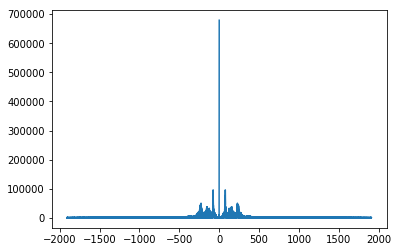

In [13]:
plt.plot(fft_freqs, np.abs(bump_fft));

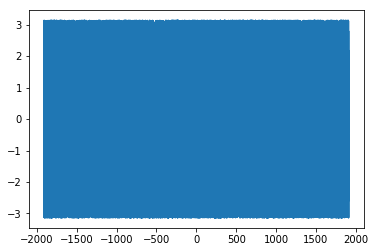

In [14]:
plt.plot(fft_freqs, np.angle(bump_fft));

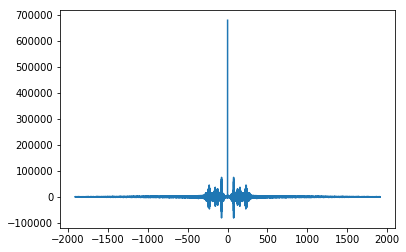

In [15]:
plt.plot(fft_freqs, np.real(bump_fft));

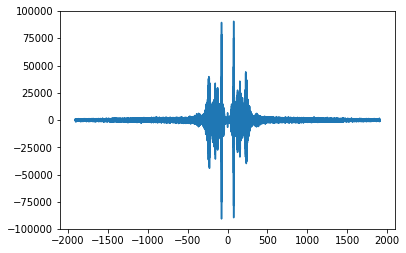

In [16]:
plt.plot(fft_freqs, np.imag(bump_fft));

Lots of low frequency components. 

(0, 100000)

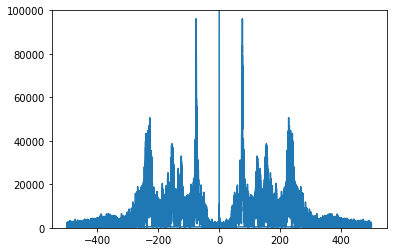

In [17]:
plt.plot(fft_freqs[np.abs(fft_freqs) < 500], np.abs(bump_fft)[np.abs(fft_freqs) < 500])
plt.ylim(0, 100000)

In [18]:
fft_freqs[1]

-0.02544622908718787

### Short-Time DFT

In [22]:
st_size = 1500 # chunk size
overlap_size = 500 # overlap between chunks
f_cutoff = 500 # frequency cutoff in kHz

# define an iterator for returning chunks of an array
# with some overlap between chunks
def overlapping_chunk(x, length, overlap):
    st_cursor = 0
    while (st_cursor < len(x)):
        if (st_cursor < len(x) - length):
            yield x[st_cursor:st_cursor+length]
        elif (st_cursor < len(x)):
            yield x[st_cursor:]
        st_cursor += st_size - overlap
    
# frequency values returned by fft()
freqs = np.fft.fftfreq(st_size) / t_step / 1000 # in kHz

# iterate over the data sample using the overlapping chunk iterator
stdft_list = []
for stdft_time in overlapping_chunk(bump_sample['acoustic_data'], st_size, overlap_size):
    # perform fft on each chunk
    stdft_freq = fft(stdft_time, n = st_size)
    # filter out frequencies above a given value
    stdft_freq_filtered = stdft_freq[np.abs(freqs) <= f_cutoff]
    # add fft results to the results list
    stdft_list.append(np.fft.fftshift(stdft_freq_filtered))
    
# combine results to create a matrix
stdft_stack = np.stack(stdft_list, axis=1)

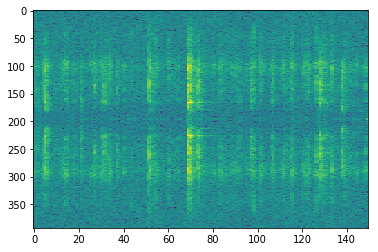

In [23]:
plt.imshow(np.log(np.abs(stdft_stack)), aspect='auto');

## Wavelet Analysis

- Info on wavelet selection [from the MATLAB docs](https://www.mathworks.com/help/wavelet/gs/choose-a-wavelet.html)
- Wavelet support on noisy data [again from MATLAB](https://www.mathworks.com/help/wavelet/gs/effect-of-wavelet-support-on-noisy-data.html)

## LSTM Model Using STDFT

In [2]:
from prepare_data import LANLDataLoader

loader = LANLDataLoader()
data_train, target_train = loader.load_train_data(n_samples=100)
data_val, target_val = loader.load_train_data(n_samples=50)

2019-03-28 17:45:56,881 - DEBUG - Loading training data...
2019-03-28 17:47:50,718 - DEBUG - Done
2019-03-28 17:47:50,721 - DEBUG - Preparing 100 random samples...
2019-03-28 17:47:52,450 - DEBUG - Calculating rolling statistics...
2019-03-28 17:47:52,481 - DEBUG - Performing DFT...
2019-03-28 17:47:52,501 - DEBUG - Scaling data...
2019-03-28 17:48:59,758 - DEBUG - Calculating input shapes...
2019-03-28 17:49:00,444 - DEBUG - Done
2019-03-28 17:49:00,446 - DEBUG - Preparing 50 random samples...
2019-03-28 17:49:01,003 - DEBUG - Calculating rolling statistics...
2019-03-28 17:49:01,025 - DEBUG - Performing DFT...
2019-03-28 17:49:01,033 - DEBUG - Scaling data...
2019-03-28 17:49:39,042 - DEBUG - Calculating input shapes...
2019-03-28 17:49:39,896 - DEBUG - Done


In [3]:
from keras.models import Sequential, Model
from keras.layers import CuDNNLSTM, LSTM, Dense, Dropout, Input, Reshape, concatenate, Permute
from keras.regularizers import l2

In [4]:
stat_shape, stdft_shape = loader.get_input_shape()

stat_input = Input(shape=stat_shape, name='stat_input')
stat_permute = Permute(dims=(2, 1), name='stat_permute')(stat_input)
stat_lstm = LSTM(4, name='stat_lstm')(stat_permute)

stdft_input = Input(shape=stdft_shape, name='stdft_input')
stdft_permute = Permute(dims=(2, 1), name='stdft_permute')(stdft_input)
stdft_lstm = LSTM(16, name='stdft_lstm')(stdft_permute)

combined = concatenate([stat_lstm, stdft_lstm], name='combined')
combined_dense = Dense(64, name='combined_dense')(combined)
output = Dense(1, name='output')(combined_dense)

model = Model(inputs=[stat_input, stdft_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2019-03-28 17:49:40,123 - WARNING - From /home/sean/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stat_input (InputLayer)         (None, 29, 4)        0                                            
__________________________________________________________________________________________________
stdft_input (InputLayer)        (None, 29, 2619)     0                                            
__________________________________________________________________________________________________
stat_permute (Permute)          (None, 4, 29)        0           stat_input[0][0]                 
__________________________________________________________________________________________________
stdft_permute (Permute)         (None, 2619, 29)     0           stdft_input[0][0]                
__________________________________________________________________________________________________
stat_lstm 

In [5]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()

In [6]:
history = model.fit([data.compute() for data in data_train], target_train, 
                    validation_data=([data.compute() for data in data_val], target_val), 
                    epochs=25, batch_size=64, verbose=2, callbacks=[time_callback])

Instructions for updating:
Use tf.cast instead.


2019-03-28 17:52:03,829 - WARNING - From /home/sean/.local/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 100 samples, validate on 50 samples
Epoch 1/25
 - 7s - loss: 33.6254 - mean_squared_error: 33.6254 - val_loss: 40.9227 - val_mean_squared_error: 40.9227
Epoch 2/25
 - 5s - loss: 32.7112 - mean_squared_error: 32.7112 - val_loss: 39.9011 - val_mean_squared_error: 39.9011
Epoch 3/25
 - 4s - loss: 31.7911 - mean_squared_error: 31.7911 - val_loss: 38.8868 - val_mean_squared_error: 38.8868
Epoch 4/25
 - 4s - loss: 30.9106 - mean_squared_error: 30.9106 - val_loss: 37.8619 - val_mean_squared_error: 37.8619
Epoch 5/25
 - 4s - loss: 30.0161 - mean_squared_error: 30.0161 - val_loss: 36.8138 - val_mean_squared_error: 36.8138
Epoch 6/25
 - 4s - loss: 29.0884 - mean_squared_error: 29.0884 - val_loss: 35.7190 - val_mean_squared_error: 35.7190
Epoch 7/25
 - 5s - loss: 28.0945 - mean_squared_error: 28.0945 - val_loss: 34.5579 - val_mean_squared_error: 34.5579
Epoch 8/25
 - 5s - loss: 27.0275 - mean_squared_error: 27.0275 - val_loss: 33.3022 - val_mean_squared_error: 33.3022
Epoch 9/25
 - 5s - 

In [7]:
history.history['val_loss'][-1]

13.501792907714844

In [8]:
np.sum(time_callback.times)

104.01636791229248

In [9]:
test_data, test_labels = loader.load_test_data()

2019-03-28 17:53:50,457 - DEBUG - Preparing test data
2019-03-28 17:54:44,159 - DEBUG - Calculating rolling statistics...
2019-03-28 17:54:44,706 - DEBUG - Performing DFT...
2019-03-28 17:54:44,722 - DEBUG - Scaling data...
2019-03-28 17:54:44,734 - DEBUG - Done


In [10]:
predictions = model.predict([data[:10, :].compute() for data in test_data])

In [11]:
predictions.squeeze()

array([5.622105 , 4.527251 , 5.5846148, 5.1262403, 5.831129 , 1.5425136,
       4.805275 , 5.4108543, 5.340023 , 5.2237854], dtype=float32)

In [15]:
import re
regex = re.compile('.csv')

pd.DataFrame({
    'seg_id': [re.sub(regex, '', label) for label in test_labels[:10]],
    'time_to_failure': predictions.squeeze()
})

,seg_id,time_to_failure
0,seg_00030f,5.622105
1,seg_0012b5,4.527251
2,seg_00184e,5.584615
3,seg_003339,5.126240
4,seg_0042cc,5.831129
5,seg_004314,1.542514
6,seg_004cd2,4.805275
7,seg_004ee5,5.410854
8,seg_004f1f,5.340023
9,seg_00648a,5.223785
